In [1]:
%matplotlib inline

import json, nltk, io, pickle
import numpy as np
from itertools import chain

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Read data

In [2]:
with open('/pio/data/data/squad/train-v1.1.json') as f:
    train = json.load(f)

In [3]:
with open('/pio/data/data/squad/dev-v1.1.json') as f:
    dev = json.load(f)

# Indexer quality check

## train

In [4]:
data_simple = []

for par in train['data']:    
    for con in par['paragraphs']:        
        for q in con['qas']:
            question = q['question']            
            answers = []
            
            for ans in q['answers']:
                text = ans['text']
                ans_start = ans['answer_start']
                
                answers.append((ans_start, text))
                
            data_simple.append([answers[0][1], question])

In [6]:
with open('/pio/data/data/squad/other/pars.wiki.train.20.norephrase.json') as f:
    wiki_pars = json.load(f)

In [7]:
pos_found = []

for k in range(1, 21):
    data_pos = []

    for i in range(len(data_simple)):
        a, q = data_simple[i]
        found = False
        for _, p in wiki_pars[i][:k]:
            if a in p:
                found = True
                data_pos.append([i, q, p])
                break
#         if not found and wiki_pars[i]:
#             print "No positive example for question", i
    pos_found.append(len(data_pos))  

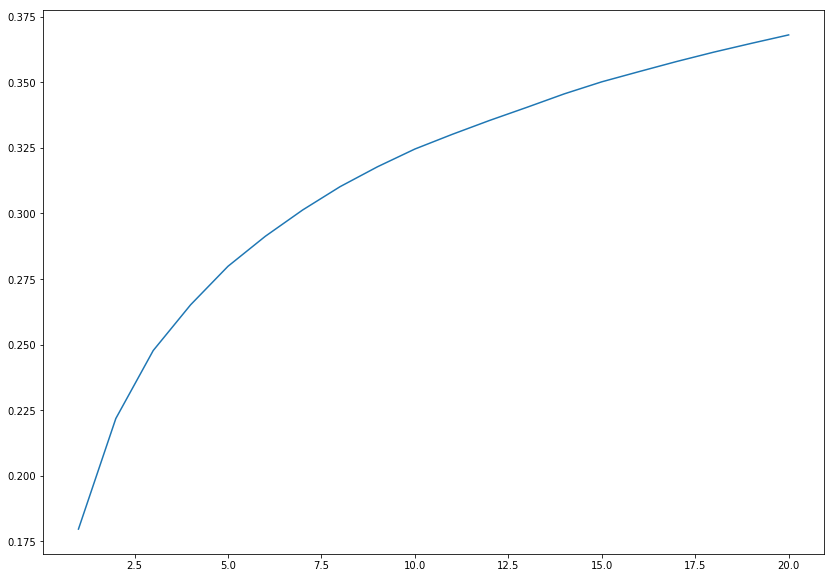

In [11]:
plt.figure(figsize=(14, 10))

# plt.xticks(np.arange(min(pos_found), max(pos_found)+1, 1000.0))
plt.plot(range(1,21), [float(d) / len(data_simple) for d in pos_found])
plt.savefig('/pio/scratch/1/i258346/20norephrase.png')

## dev

In [4]:
data_simple_dev = []

for par in dev['data']:    
    for con in par['paragraphs']:        
        for q in con['qas']:
            question = q['question']            
            answers = []
            
            for ans in q['answers']:
                text = ans['text']
                ans_start = ans['answer_start']
                
                answers.append((ans_start, text))
                
            data_simple_dev.append([[a[1] for a in answers], question])

In [8]:
def dev_recall(wiki_pars):
    pos_found = []

    for k in range(1, max(map(len, wiki_pars)) + 1):
        pos = 0
        for i in range(len(data_simple_dev)):
            anss, q = data_simple_dev[i]
            found = False
            for _, p in wiki_pars[i][:k]:
                for a in anss:
                    if a in p:
                        found = True
                        pos += 1
                        break
                if found:
                    break
        pos_found.append(pos)
    return [float(d) / len(data_simple_dev) for d in pos_found]

In [9]:
with open('/pio/data/data/squad/other/pars.dev.wiki3M.20.rephrase2.json') as f:
    wiki_pars = json.load(f)
    
res20reph3M = dev_recall(wiki_pars)

In [10]:
with open('/pio/data/data/squad/other/pars.dev.wiki1M.20.rephrase2.json') as f:
    wiki_pars = json.load(f)
    
res20reph = dev_recall(wiki_pars)

In [11]:
with open('/pio/data/data/squad/other/pars.dev.wiki3M.20.norephrase.json') as f:
    wiki_pars = json.load(f)
    
res203M = dev_recall(wiki_pars)

In [12]:
with open('/pio/data/data/squad/other/pars.dev.wiki1M.20.norephrase.json') as f:
    wiki_pars = json.load(f)
    
res20 = dev_recall(wiki_pars)

In [30]:
with open('/pio/data/data/squad/other/pars.dev.wiki3M.20.rephrase2.json') as f:
    wiki_pars1 = json.load(f)
    
with open('/pio/data/data/squad/other/pars.dev.wiki3M.20.norephrase.json') as f:
    wiki_pars2 = json.load(f)
    
wiki_pars = []

for i in range(len(wiki_pars1)):
    wiki_pars.append(sorted(wiki_pars1[i] + wiki_pars2[i], reverse=True))
    
res203Mboth_all = dev_recall(wiki_pars)    

In [32]:
res203Mboth = res203Mboth_all[:20]
res203Mboth_all = [res203Mboth_all[i] for i in range(1, 40, 2)]

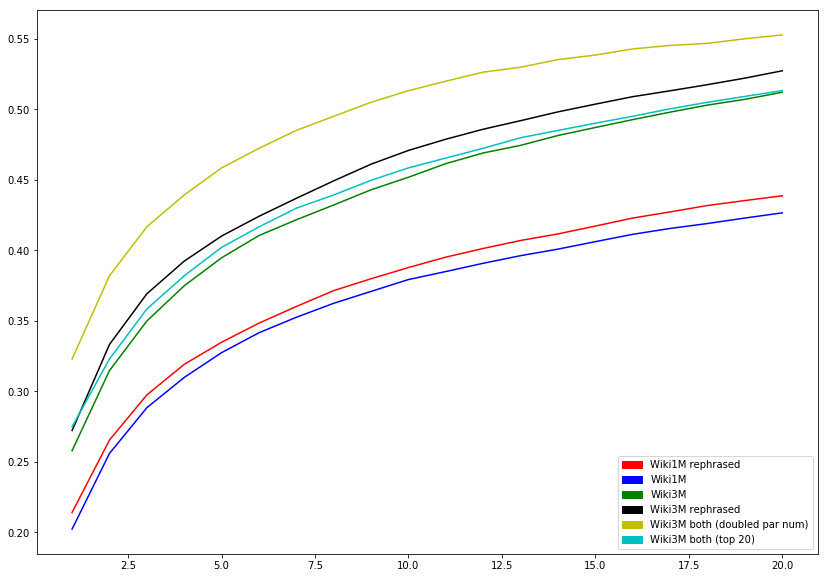

In [56]:
plt.figure(figsize=(14, 10))

# plt.xticks(np.arange(min(pos_found), max(pos_found)+1, 1000.0))
plt.plot(range(1,21), res20reph, 'r')
plt.plot(range(1,21), res20, 'b')
plt.plot(range(1,21), res203M, 'g')
plt.plot(range(1,21), res20reph3M, 'k')
plt.plot(range(1,21), res203Mboth_all, 'y')
plt.plot(range(1,21), res203Mboth, 'c')


p1 = mpatches.Patch(color='r', label='Wiki1M rephrased')
p2 = mpatches.Patch(color='b', label='Wiki1M')
p3 = mpatches.Patch(color='g', label='Wiki3M')
p4 = mpatches.Patch(color='k', label='Wiki3M rephrased')
p5 = mpatches.Patch(color='y', label='Wiki3M both (doubled par num)')
p6 = mpatches.Patch(color='c', label='Wiki3M both (top 20)')
plt.legend(handles=[p1, p2, p3, p4, p5, p6], loc=4)
plt.savefig('/pio/scratch/1/i258346/indexer_squad_dev.png')